# Part g): Analysis of real data 

### Importing terrain data

/tmp/ipykernel_25451/3899933975.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread("SRTM_data_Norway_1.tif")


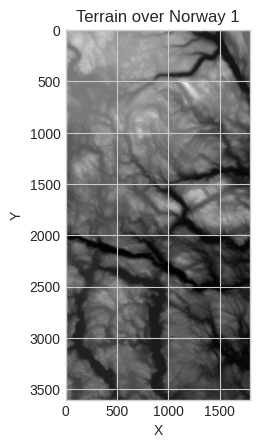

(3601, 1801)


In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import functions as f
plt.style.use('seaborn-v0_8-whitegrid')

# Load the terrain
terrain1 = imread("SRTM_data_Norway_1.tif")
# Show the terrain
plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(terrain1, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
print(terrain1.shape)


### Analysis of terrain data

In [2]:

# Load the terrain data
terrain_data = imread("SRTM_data_Norway_1.tif")

# Define the x and y coordinates
#x = np.arange(0, terrain_data.shape[1])
#y = np.arange(0, terrain_data.shape[0])
x = np.arange(0,400)
y = np.arange(0,400)

# Create a meshgrid of the x and y coordinates
xv, yv = np.meshgrid(x, y)
z = terrain_data[1200:1600,1300:1700]

terrain_data.shape
print(x.shape)
print(y.shape)
print(z.shape)

(400,)
(400,)
(400, 400)


/tmp/ipykernel_25451/883877443.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain_data = imread("SRTM_data_Norway_1.tif")


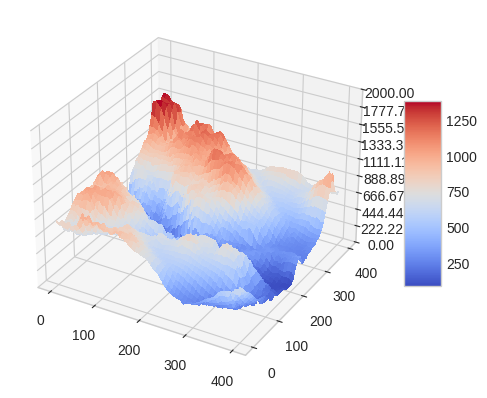

In [3]:
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(xv, yv, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0,2000)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

"At the end, you should present a critical evaluation of your results and discuss
the applicability of these regression methods to the type of data presented here
(either the terrain data we propose or other data sets)"

# OLS Reproduction

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
x = np.arange(0,160000)
y = np.arange(0,160000)
z = z.ravel().reshape(-1,1)

degrees = np.arange(1, 11)

beta_values = []
mse_values = np.zeros(len(degrees))
R2_values = np.zeros(len(degrees))


for i, degree in enumerate(degrees): 
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X = poly_features.fit_transform(np.column_stack((x, y)))

    # Split the data into training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    # Scale and center the data
    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    z_train = scaler.fit_transform(z_train)
    z_test = scaler.transform(z_test)

    #Calculating OLSbeta, ztilde, mse and R2
    OLSbeta = f.beta_OLS(X_train, z_train)
    ztilde = f.z_predict(X_test, OLSbeta)
    mse = f.mse(z_test, ztilde)
    R2 = f.r2(z_test, ztilde)

    #Adding the values to the arrays
    beta_values.append(OLSbeta)
    mse_values[i] = mse
    R2_values[i] = R2

   

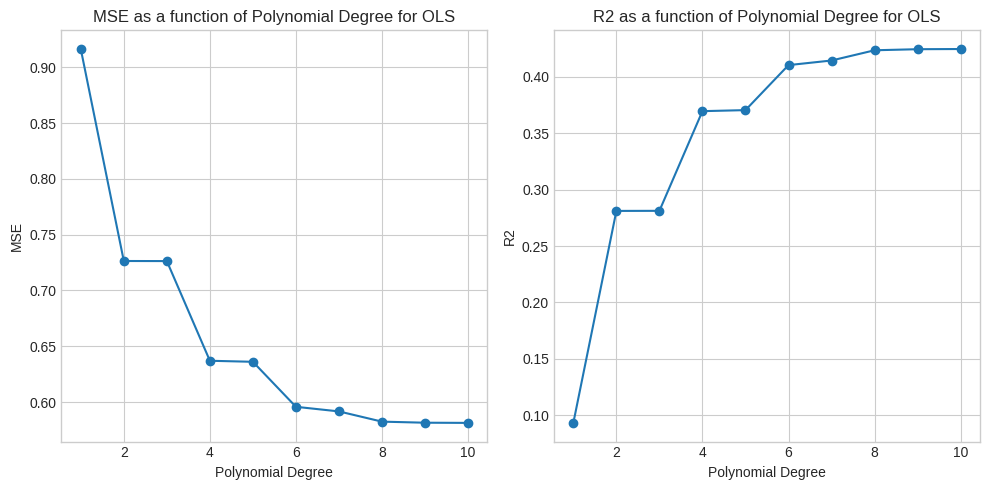

In [6]:
# Plotting MSE and R2 scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, mse_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE as a function of Polynomial Degree for OLS')

plt.subplot(1, 2, 2)
plt.plot(degrees, R2_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2')
plt.title('R2 as a function of Polynomial Degree for OLS')
plt.tight_layout()
plt.show()

degree 0 betavalues 3
[[0.       ]
 [0.1498454]
 [0.1498454]]
 
degree 1 betavalues 6
[[ 0.        ]
 [-0.68420115]
 [-0.68420115]
 [ 0.57429369]
 [ 0.57429369]
 [ 0.57429369]]
 
degree 2 betavalues 10
[[ 0.        ]
 [-0.7578508 ]
 [-0.7578508 ]
 [ 0.7011031 ]
 [ 0.7011031 ]
 [ 0.7011031 ]
 [-0.06029693]
 [-0.06029693]
 [-0.06029693]
 [-0.06029693]]
 
degree 3 betavalues 15
[[ 0.        ]
 [ 1.89433016]
 [ 1.89433016]
 [-7.51743269]
 [-7.51743269]
 [-7.51743269]
 [ 9.05902894]
 [ 9.05902894]
 [ 9.05902894]
 [ 9.05902894]
 [-3.43243791]
 [-3.43243791]
 [-3.43243791]
 [-3.43243791]
 [-3.43243791]]
 
degree 4 betavalues 21
[[ 0.        ]
 [ 1.3762378 ]
 [ 1.3762378 ]
 [-5.02067216]
 [-5.02067216]
 [-5.02067216]
 [ 4.30999221]
 [ 4.30999221]
 [ 4.30999221]
 [ 4.30999221]
 [ 0.58953529]
 [ 0.58953529]
 [ 0.58953529]
 [ 0.58953529]
 [ 0.58953529]
 [-1.26354935]
 [-1.26354935]
 [-1.26354935]
 [-1.26354935]
 [-1.26354935]
 [-1.26354934]]
 
degree 5 betavalues 28
[[  0.        ]
 [ -3.09190415

Text(0.5, 1.0, 'Beta values as a function of a Polynomial Degree for OLS')

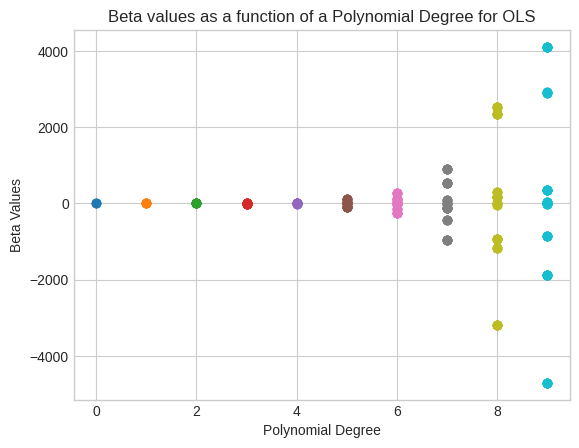

In [7]:
for degree, values in enumerate(beta_values):
    print("degree", degree, "betavalues", len(values))
    print(values)
    print(" ")
    degrees = np.repeat(degree, len(values))
    plt.scatter(degrees, values)

plt.xlabel('Polynomial Degree')
plt.ylabel('Beta Values')
plt.title('Beta values as a function of a Polynomial Degree for OLS')


# Ridge reproduction

In [8]:

x = np.arange(0,160000)
y = np.arange(0,160000)
z = z.ravel().reshape(-1,1)

degrees = np.arange(1, 11)

beta_ridge_values = []
mse_ridge_values = np.zeros(len(degrees))
R2_ridge_values = np.zeros(len(degrees))

lambda_values = np.logspace(-4, 4, 9)

for i, degree in enumerate(degrees): 
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X = poly_features.fit_transform(np.column_stack((x, y)))

    # Split the data into training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    # Scale and center the data
    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    z_train = scaler.fit_transform(z_train)
    z_test = scaler.transform(z_test)
    mse_temp = np.zeros(len(lambda_values))

    for j, lambda_ in enumerate(lambda_values):
        #Calculating OLSbeta, ztilde, mse and R2
        Ridgebeta = f.beta_ridge(X_train, z_train, lambda_)
        ztilde = f.z_predict(X_test, Ridgebeta)
        mse = f.mse(z_test, ztilde)
        mse_temp[j] = mse

    j = np.argmin(mse_temp)
    Ridgebeta = f.beta_ridge(X_train, z_train, lambda_values[j])
    ztilde = f.z_predict(X_test, Ridgebeta)

    #Adding the values to the arrays
    beta_ridge_values.append(Ridgebeta)
    mse_ridge_values[i] = f.mse(z_test, ztilde)
    R2_ridge_values[i] = f.r2(z_test, ztilde)



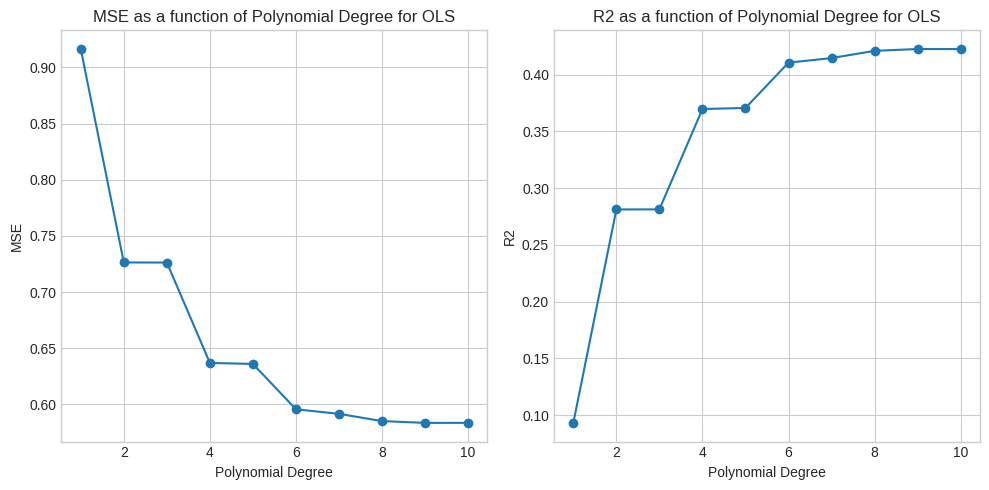

In [9]:
# Plotting MSE and R2 scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, mse_ridge_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE as a function of Polynomial Degree for OLS')

plt.subplot(1, 2, 2)
plt.plot(degrees, R2_ridge_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2')
plt.title('R2 as a function of Polynomial Degree for OLS')
plt.tight_layout()
plt.show()

degree 0 betavalues 3
[[0.        ]
 [0.14984542]
 [0.14984539]]
 
degree 1 betavalues 6
[[ 0.        ]
 [-0.68420118]
 [-0.6842011 ]
 [ 0.5742937 ]
 [ 0.57429365]
 [ 0.5742937 ]]
 
degree 2 betavalues 10
[[ 0.        ]
 [-0.748421  ]
 [-0.748421  ]
 [ 0.68579785]
 [ 0.68579785]
 [ 0.68579785]
 [-0.05329844]
 [-0.05329844]
 [-0.05329844]
 [-0.05329844]]
 
degree 3 betavalues 15
[[ 0.        ]
 [ 1.8802418 ]
 [ 1.8802418 ]
 [-7.47553655]
 [-7.47553672]
 [-7.47553672]
 [ 9.01387075]
 [ 9.01387077]
 [ 9.01387084]
 [ 9.01387076]
 [-3.41580398]
 [-3.41580398]
 [-3.41580398]
 [-3.41580398]
 [-3.41580398]]
 
degree 4 betavalues 21
[[ 0.        ]
 [ 1.37619979]
 [ 1.37620004]
 [-0.77903776]
 [-7.14123481]
 [-7.1412358 ]
 [ 4.57327235]
 [ 4.10402297]
 [ 4.28072621]
 [ 4.28072621]
 [ 0.59256731]
 [ 0.5882466 ]
 [ 0.58927928]
 [ 0.58927928]
 [ 0.58954478]
 [-1.26361873]
 [-1.26362573]
 [-1.26362569]
 [-1.26362568]
 [-1.26362567]
 [-1.26362743]]
 
degree 5 betavalues 28
[[  0.        ]
 [ -2.94832

Text(0.5, 1.0, 'Beta values as a function of a Polynomial Degree for Ridge')

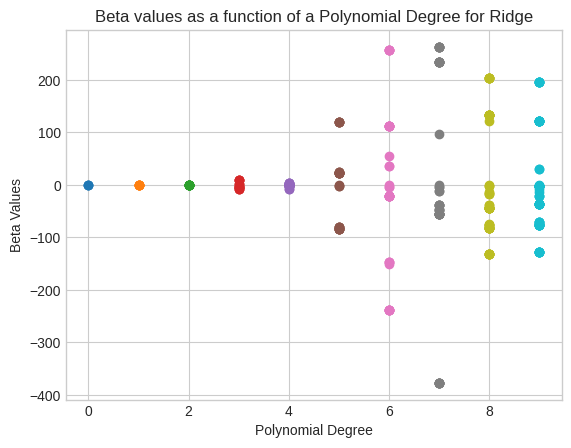

In [10]:
for degree, values in enumerate(beta_ridge_values):
    print("degree", degree, "betavalues", len(values))
    print(values)
    print(" ")
    degrees = np.repeat(degree, len(values))
    plt.scatter(degrees, values)

plt.xlabel('Polynomial Degree')
plt.ylabel('Beta Values')
plt.title('Beta values as a function of a Polynomial Degree for Ridge')

# Lasso Reproduction

In [11]:
x = np.arange(0,160000)
y = np.arange(0,160000)
z = z.ravel().reshape(-1,1)

degrees = np.arange(1, 4)

beta_lasso_values = []
mse_lasso_values = np.zeros(len(degrees))
R2_lasso_values = np.zeros(len(degrees))

lambda_values = np.logspace(-4, 4, 5)

for i, degree in enumerate(degrees): 
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X = poly_features.fit_transform(np.column_stack((x, y)))

    # Split the data into training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    # Scale and center the data
    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scaler = StandardScaler(with_std=True, with_mean=True) #Subtracting the mean and dividing by the standard deviation to scale/normalize the data
    z_train = scaler.fit_transform(z_train)
    z_test = scaler.transform(z_test)
    mse_temp = np.zeros(len(lambda_values))

    for j, lambda_ in enumerate(lambda_values):
        # Create and fit the linear regression model
        model = Lasso(alpha = lambda_values[j], fit_intercept=False, max_iter=1000000)
        model.fit(X_train, z_train)

        # Make predictions for training and test data
        z_train_pred = model.predict(X_train)
        z_test_pred = model.predict(X_test)
        print(z_train_pred.shape)

        # Compute mean squared error for training and test data
        #mse_train = f.mse(z_train, z_train_pred)
        mse_test = f.r2(z_test, z_test_pred)

        mse_temp[j] = mse_test

    j = np.argmin(mse_temp)
     # Create and fit the linear regression model with the optimal lambda value
    model = Lasso(alpha = lambda_values[j], fit_intercept=False, max_iter=1000000)
    model.fit(X_train, z_train)

    # Make predictions for training and test data
    z_train_pred = model.predict(X_train)
    z_test_pred = model.predict(X_test)

    Lassobeta = model.coef_

    #Adding the values to the arrays
    beta_lasso_values.append(Lassobeta)
    mse_lasso_values[i] = f.mse(z_test, z_test_pred)
    R2_lasso_values[i] = f.r2(z_test, z_test_pred)


ValueError: Found input variables with inconsistent numbers of samples: [1600, 160000]

In [ ]:
# Plotting MSE and R2 scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, mse_lasso_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE as a function of Polynomial Degree for OLS')

plt.subplot(1, 2, 2)
plt.plot(degrees, R2_lasso_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2')
plt.title('R2 as a function of Polynomial Degree for OLS')
plt.tight_layout()
plt.show()

In [ ]:
for degree, values in enumerate(beta_lasso_values):
    print("degree", degree, "betavalues", len(values))
    print(values)
    print(" ")
    degrees = np.repeat(degree, len(values))
    plt.scatter(degrees, values)

plt.xlabel('Polynomial Degree')
plt.ylabel('Beta Values')
plt.title('Beta values as a function of a Polynomial Degree for Lasso')